In [2]:
%%capture
! pip install gym gym[box2d]
! pip install ipywidgets

In [3]:
%%capture
# simple neural network implementation of qlearning
import gym
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import layers, optimizers
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from collections import deque 

# RL using OpenAI Gym: https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
# Deep Q-Learning: https://github.com/adventuresinML/adventures-in-ml-code/blob/master/r_learning_tensorflow.py
# Lunar Lander: https://github.com/vsaveris/lunar-lander-DQN

/Users/broxoli/miniforge3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


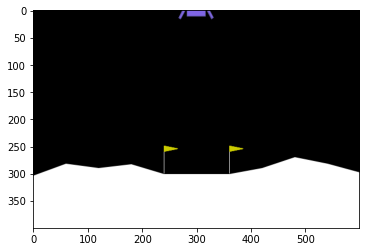

In [4]:
seed = 111

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For Kaggle
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

"""
Observation Space has 8 states
===============================

1- The coordinates of the lander in x & y.
2- Its linear velocities in x & y.
3- Its angle.
4- Its angular velocity.
5- Two booleans that represent whether each leg is in contact with the ground or not.

Action Space has 4 discrete actions
===================================
1- Do nothing.
2- Fire left orientation engine.
3- Fire main engine.
4- Fire right orientation engine.

"""

env = gym.make("LunarLander-v2")
obs = env.reset()
image = env.render(mode='rgb_array')
plt.imshow(image)

In [5]:
def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render(mode='rgb_array')
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))
       
    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,2e9))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

In [6]:
# N_STATES = env.observation_space.shape[0]
# N_ACTIONS = env.action_space.n

# def create_model():
#     """Construct the critic network with q-values per action as output"""
#     model = keras.Sequential([
#         layers.Input(shape=(N_STATES)),
#         layers.Dense(24, activation="relu"),
#         layers.Dense(256, activation="relu"),
#         layers.Dense(32, activation="relu"),
#         layers.Dense(256, activation="relu"),
#         layers.Dense(512, activation="relu"),
#         layers.Dense(128, activation="relu"),
#         layers.Dense(N_ACTIONS, activation='linear')
#     ])
    
#     model.compile(optimizer=optimizers.Adam(.001), loss='mse')

#     return model

# model = create_model()
# model.summary()

In [7]:
# N_STATES = env.observation_space.shape[0]
# N_ACTIONS = env.action_space.n

# def create_model():
#     """Construct the critic network with q-values per action as output"""
#     model = keras.Sequential([
#         layers.Input(shape=(N_STATES)),
#         layers.Dense(128, activation="relu"),
#         layers.Dense(256, activation="relu"),
#         layers.Dense(512, activation="relu"),
#         layers.Dense(N_ACTIONS, activation='linear')
#     ])
    
#     model.compile(optimizer=optimizers.Adam(.001), loss='mse')

#     return model

# model = create_model()
# model.summary()

In [8]:
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

def create_model():
    """Construct the critic network with q-values per action as output"""
    model = keras.Sequential([
        layers.Input(shape=(N_STATES)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(N_ACTIONS, activation='linear')
    ])
    
    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

model = create_model()
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________


2022-06-27 12:42:17.468081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-27 12:42:17.469277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
GAMMA = .99
DECAY_FACTOR = .99995
BATCH_SIZE = 64
MAX_EPISODES = 1000

def Trainer(m):
    memory = []
    epsilon = 1.0

    def choosePlay(state):
        nonlocal epsilon
        random_action = lambda: np.random.randint(N_ACTIONS)
    
        def predicted_action():
            q_values = m(tf.expand_dims(state, 0))
            action = tf.squeeze(tf.argmax(q_values, axis=-1))
            return action.numpy()
        
        action =  random_action() if np.random.random() <= epsilon else predicted_action()
        epsilon *= DECAY_FACTOR

        return action
    
    def obs_to_state(obs):
        state = np.squeeze(obs)
        return state

    def play(state):
        action = choosePlay(state)
        obs, reward, done, _ = env.step(action)
        new_state = obs_to_state(obs)

        return state, action, reward, new_state, done

    def train(episodes=2, steps=1000):
        results = []

        # Record the model with the best performance.
        best_model_so_far = (0, 1000, -1000.0)
        best_model_name_fmt = 'lunar_lander.{}.h5'

        for episode_id in range(episodes):
            obs = env.reset()
            state = obs_to_state(obs)
            score = 0

            for step_id in range(steps):
                # Play to gain experience
                state, action, reward, new_state, done = play(state)
                score += reward
                new_state = np.zeros_like(state) if done else new_state
                
                # Store experience in the memory bank
                memory.append((state, action, reward, new_state))

                # Train the network with a batch of the gained experience
                batch = np.asarray(random.sample(memory, min(len(memory), BATCH_SIZE)), dtype=object)
                q_s_a = m.predict(np.stack(batch[:, 0], axis = 0))  #Q(s,a)   
                q_s_a_next = m.predict(np.stack(batch[:, 3], axis = 0))  #Q(s',a)

                for item_id in range(batch.shape[0]):
                    if np.array_equal(batch[item_id, 3], np.zeros(N_STATES)):
                        q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2]
                    else:
                        q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2] + GAMMA*np.amax(q_s_a_next[item_id, :])
                
                m.fit(np.stack(batch[:, 0], axis = 0), q_s_a, batch_size=BATCH_SIZE, verbose=0)

                if done:
                    episode_results = (step_id, score, reward, True if reward == 100 else False)
                    results.append(episode_results)

                    if score > best_model_so_far[2]:
                        current_best_model_file = Path(best_model_name_fmt.format(best_model_so_far[0]))
                        new_best_model_file = best_model_name_fmt.format(episode_id)
                        best_model_so_far = (episode_id, step_id, score)

                        m.save_weights(new_best_model_file)
                        if current_best_model_file.exists(): current_best_model_file.unlink()

                    print('Episode:', episode_id, episode_results, 'Best Model:', best_model_so_far[0], ' Epsilon:', epsilon)
                    break

        return results
    
    return train

trainer = Trainer(model)
results = trainer()

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(results, f)

model.save_weights('lunar_lander.h5')

Episode: 0 (91, -73.25115655948652, -100, False) Best Model: 0  Epsilon: 0.9954104493199486
Episode: 1 (65, -127.873556577068, -100, False) Best Model: 0  Epsilon: 0.9921309270364603


In [32]:
np.random.random()

0.44286057320354666

In [ ]:
# GAMMA = 0.95
# EXPLORATION_RATE = 0.5

# def choose_action(model, state):
#     random_action = lambda: np.random.randint(N_ACTIONS)
    
#     def predicted_action():
#         q_values = model(tf.expand_dims(state, 0))
#         action = tf.squeeze(tf.argmax(q_values, axis=-1))
#         return action.numpy()

#     # Choose between the greey move or the random move.
#     # Greedy move take the greedy approach to chose the best current action.
#     epsilon = np.random.rand()
#     action =  random_action() if epsilon <= EXPLORATION_RATE else predicted_action()

#     return action

# def obs_to_state(obs):
#     state = np.squeeze(obs)
#     return state

# def play(model, state):
#     return choose_action(model, state)

# def capped_append(memory, data, max_size=10000):
#     memory.append(data)
#     if len(memory) > max_size: memory.pop(0)

# def normalize_reward(reward, min=-150.0, max=150.0):
#     return (reward-min)/(max-min)

# def update_exploration_rate(step_id):
#     global EXPLORATION_RATE
#     if step_id > 350: EXPLORATION_RATE = .05
#     elif step_id > 150: EXPLORATION_RATE = .1
#     elif step_id > 100: EXPLORATION_RATE = .2
#     else: EXPLORATION_RATE = .5

# def batch_train(step_id, model, memory, score, bs=64, log=False):
#     update_exploration_rate(step_id)
#     batch = random.sample(memory, bs) if len(memory) > bs else memory

#     X = tf.stack([m[0] for m in batch])
#     next_X = tf.stack([m[3] for m in batch])

#     q_s_a = model.predict(X)
#     q_s_a_next = model.predict(next_X)

#     for idx, (_, action, reward, _, done) in enumerate(batch):
#         if done:
#             q_s_a[idx][action] = reward
#         else:
#             q_s_a[idx][action] = reward + GAMMA*np.amax(q_s_a_next[idx])
    
#     history = model.fit(tf.stack(X), q_s_a, batch_size=bs, epochs=1, verbose=0)

#     if log and step_id%4 == 0:
#         print('Step: ', step_id, 'Loss: ', history.history['loss'][-1], ' Score: ', score)
    
# episodes = 3
# memory = []
# last_step_memory = []
# batch_size = 64
# sims = {}
# results = []

# # Reset the environment to start training from scratch.
# obs = env.reset()

# # Record the model with the best performance.
# best_model_so_far = (0, 1000, -1000.0)
# best_model_name_fmt = 'lunar_lander.{}.h5'

# for episode_id in range(episodes):
#     images = []
#     score = 0

#     for step_id in range(1000):
#         state = obs_to_state(obs)
#         action = play(model, state)
#         obs, reward, done, _ = env.step(action)
#         score += reward

#         # Save event data to memory for training later
#         capped_append(memory, (state, action, reward, obs_to_state(obs), done))
        
#         # Save the current game visuals
#         save_visuals(env, images)

#         # Train model based on the memory
#         if step_id%20 == 0: batch_train(step_id, model, memory, score)

#         if done:
#             episode_results = (step_id, score, reward, True if reward == 100 else False)
#             results.append(episode_results)

#             if score > best_model_so_far[2]:
#                 current_best_model_file = Path(best_model_name_fmt.format(best_model_so_far[0]))
#                 new_best_model_file = best_model_name_fmt.format(episode_id)
#                 best_model_so_far = (episode_id, step_id, score)

#                 model.save_weights(new_best_model_file)
#                 if current_best_model_file.exists(): current_best_model_file.unlink()

#             print('Episode:', episode_id, episode_results, 'Best Model:', best_model_so_far[0])
#             break

#     obs = env.reset()
#     save_frames_as_gif(sims, episode_id, images)

# with open('lunar_lander.results.pkl', 'wb') as f:
#     pickle.dump(results, f)

# model.save_weights('lunar_lander.h5')

lunar_lander.0.h5 (0, 218, -729.7280958724585)
Episode: 0 (218, -729.7280958724585, -100, False) Best Model: 0
lunar_lander.0.h5 (1, 79, -681.2271478842425)
Episode: 1 (79, -681.2271478842425, -100, False) Best Model: 1
lunar_lander.1.h5 (2, 68, -152.37046854339144)
Episode: 2 (68, -152.37046854339144, -100, False) Best Model: 2


In [30]:
def display_episodes(sims, episodes):
    html_preable = '<div style="display: flex; flex-wrap: wrap;">'
    html_postamble = '</div>'
    html_body = ''
    for episode_id in episodes:
        content_preamble = '<div style="margin: 0 .2%;  width:20%">'
        content_postamble = '</div>'
        gif_name = sims[episode_id]

        content = '<img src="{}"/>\n<p style="text-align: center">Episode: {}</p>'.format(gif_name, episode_id)
        html_body += content_preamble + content + content_postamble

    display(HTML(html_preable + html_body + html_postamble))

display_episodes(sims, range(episodes))

NameError: name 'sims' is not defined

,Steps,Score,Final Reward,Done,R50_Scores,R80_Scores,Crashed
0,84,-132.742504,-100,False,-132.742504,-132.742504,True
1,102,-265.128220,-100,False,-198.935362,-198.935362,True


Successes: 0 Crashes: 2 Timeouts: 0
Top Scores


,Steps,Score,Final Reward,Done,R50_Scores,R80_Scores,Crashed
0,84,-132.742504,-100,False,-132.742504,-132.742504,True
1,102,-265.128220,-100,False,-198.935362,-198.935362,True


Training Benchmarks


,Start,End,Count,Successes,Crashes,Timeouts
0,0,50,0,0,0,0
1,50,150,2,0,2,0
2,150,350,0,0,0,0
3,350,1000,0,0,0,0


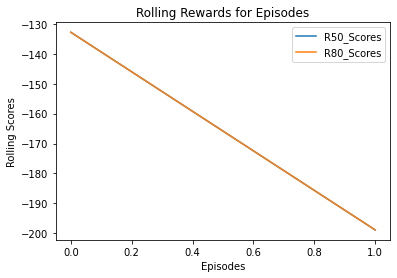

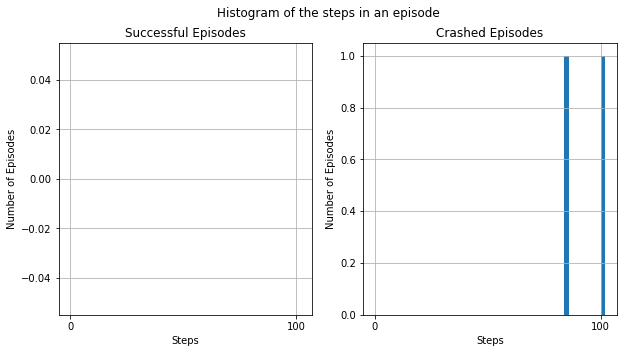

In [29]:
def load_results(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        columns = ['Steps', 'Score', 'Final Reward', 'Done']
        return pd.DataFrame(results, columns=columns)

def show_results(df):
    df['R50_Scores'] = df.rolling(window=50, min_periods=1).mean()['Score']
    df['R80_Scores'] = df.rolling(window=80, min_periods=1).mean()['Score']
    df['Done'] = df['Final Reward'] == 100
    df['Crashed'] = df['Final Reward'] == -100

    # Plot rolling scores
    plt.plot(df['R50_Scores'], label='R50_Scores')
    plt.plot(df['R80_Scores'], label='R80_Scores')
    plt.legend()
    plt.title('Rolling Rewards for Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Rolling Scores')

    display(df)

def summarize_results(file):
    df = load_results(file)
    show_results(df)

    successes = len(df[df['Done'] == True])
    crashes = len(df[df['Crashed'] == True])
    timeouts = len(df.loc[(df['Crashed'] == False) & (df['Done'] == False)])
    print('Successes:', successes, 'Crashes:', crashes, 'Timeouts:', timeouts)

    sorted_scores = df.sort_values('Score', ascending=False)
    print('Top Scores')
    display(sorted_scores)
    

    steps_benchmarks = [0, 50, 150, 350, 1000]
    # steps_benchmarks = [0, 50, 100, 300, 500, 1000]
    benchmark_df = pd.DataFrame(columns=['Start', 'End', 'Count', 'Successes', 'Crashes', 'Timeouts'])

    for bm in range(1, len(steps_benchmarks)):
        start, end = steps_benchmarks[bm - 1], steps_benchmarks[bm]
        range_cond = (df['Steps']>=start) & (df['Steps']<end)

        count = len(df.loc[range_cond])
        successes = len(df.loc[range_cond & df['Done'] == True])
        crashes = len(df.loc[range_cond & df['Crashed'] == True])
        timeouts = len(df.loc[range_cond & (df['Crashed'] == False) & (df['Done'] == False)])

        benchmark_df.loc[bm-1] = (start, end, count, successes, crashes, timeouts)
    
    # Training Benchmarks
    print('Training Benchmarks')
    display(benchmark_df)

    # Episode Steps Histogram
    successes_df = df.loc[df['Done'] == True]['Steps']
    crashes_df = df.loc[df['Crashed'] == True]['Steps']

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
    successes_df.hist(ax=axes[0])
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Number of Episodes')
    axes[0].set_title('Successful Episodes')
    axes[0].set_xticks(range(0, 1000, 100))

    crashes_df.hist(ax=axes[1])
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Number of Episodes')
    axes[1].set_title('Crashed Episodes')
    fig.suptitle('Histogram of the steps in an episode')

# summarize_results('lunar_lander.kaggle.15.results.pkl')
summarize_results('lunar_lander.results.pkl')

,Steps,Score,Final Reward,Done,R50_Scores,R80_Scores,Crashed
0,95,-364.693748,-100.000000,False,-364.693748,-364.693748,True
1,73,-182.122965,-100.000000,False,-273.408357,-273.408357,True
2,89,-195.729942,-100.000000,False,-247.515552,-247.515552,True
3,64,-163.847493,-100.000000,False,-226.598537,-226.598537,True
4,75,-437.762880,-100.000000,False,-268.831405,-268.831405,True
...,...,...,...,...,...,...,...
995,627,-145.198144,-100.000000,False,-63.320601,-55.212849,True
996,999,-83.089201,-3.708867,False,-69.675639,-55.460766,False
997,999,8.171326,1.773729,False,-67.068531,-52.857037,False
998,999,-124.646168,-2.661721,False,-66.694942,-53.877397,False


Successes: 100 Crashes: 461 Timeouts: 439
Top Scores


,Steps,Score,Final Reward,Done,R50_Scores,R80_Scores,Crashed
395,255,319.032267,100.0,True,-40.774541,-46.354587,False
137,304,311.406715,100.0,True,-78.183006,-113.066478,False
589,236,291.738083,100.0,True,-17.982640,-18.274544,False
853,404,289.840794,100.0,True,-40.251848,-35.664730,False
791,315,288.061974,100.0,True,-51.084514,-68.998567,False
...,...,...,...,...,...,...,...
18,135,-511.424450,-100.0,False,-278.574051,-278.574051,True
199,598,-521.018925,-100.0,False,-74.003728,-63.562247,True
10,73,-543.484228,-100.0,False,-311.686360,-311.686360,True
23,397,-546.538948,-100.0,False,-299.388655,-299.388655,True


Training Benchmarks


,Start,End,Count,Successes,Crashes,Timeouts
0,0,50,0,0,0,0
1,50,150,223,0,223,0
2,150,350,153,17,136,0
3,350,1000,624,83,102,439


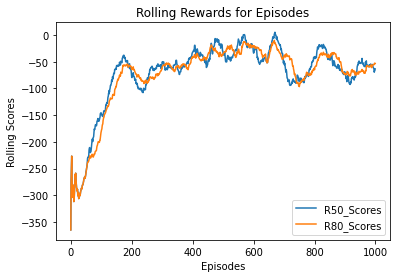

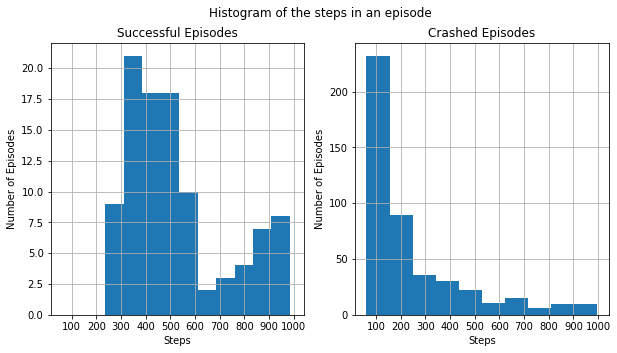

In [ ]:
def load_results(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        columns = ['Steps', 'Score', 'Final Reward', 'Done']
        return pd.DataFrame(results, columns=columns)

def show_results(df):
    df['R50_Scores'] = df.rolling(window=50, min_periods=1).mean()['Score']
    df['R80_Scores'] = df.rolling(window=80, min_periods=1).mean()['Score']
    df['Done'] = df['Final Reward'] == 100
    df['Crashed'] = df['Final Reward'] == -100

    # Plot rolling scores
    plt.plot(df['R50_Scores'], label='R50_Scores')
    plt.plot(df['R80_Scores'], label='R80_Scores')
    plt.legend()
    plt.title('Rolling Rewards for Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Rolling Scores')

    display(df)

def summarize_results(file):
    df = load_results(file).iloc[:1000, 0:]
    show_results(df)

    successes = len(df[df['Done'] == True])
    crashes = len(df[df['Crashed'] == True])
    timeouts = len(df.loc[(df['Crashed'] == False) & (df['Done'] == False)])
    print('Successes:', successes, 'Crashes:', crashes, 'Timeouts:', timeouts)

    sorted_scores = df.sort_values('Score', ascending=False)
    print('Top Scores')
    display(sorted_scores)

    steps_benchmarks = [0, 50, 150, 350, 1000]
    # steps_benchmarks = [0, 50, 100, 300, 500, 1000]
    benchmark_df = pd.DataFrame(columns=['Start', 'End', 'Count', 'Successes', 'Crashes', 'Timeouts'])

    for bm in range(1, len(steps_benchmarks)):
        start, end = steps_benchmarks[bm - 1], steps_benchmarks[bm]
        range_cond = (df['Steps']>=start) & (df['Steps']<end)

        count = len(df.loc[range_cond])
        successes = len(df.loc[range_cond & df['Done'] == True])
        crashes = len(df.loc[range_cond & df['Crashed'] == True])
        timeouts = len(df.loc[range_cond & (df['Crashed'] == False) & (df['Done'] == False)])

        benchmark_df.loc[bm-1] = (start, end, count, successes, crashes, timeouts)
    
    # Training Benchmarks
    print('Training Benchmarks')
    display(benchmark_df)

    # Episode Steps Histogram
    successes_df = df.loc[df['Done'] == True]['Steps']
    crashes_df = df.loc[df['Crashed'] == True]['Steps']

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
    successes_df.hist(ax=axes[0])
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Number of Episodes')
    axes[0].set_title('Successful Episodes')
    axes[0].set_xticks(range(0, 1500, 100))

    crashes_df.hist(ax=axes[1])
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Number of Episodes')
    axes[1].set_title('Crashed Episodes')
    fig.suptitle('Histogram of the steps in an episode')

summarize_results('lunar_lander.kaggle.18.results.pkl')

,Final Reward,Score,Steps,Done,Crashed,Rolling Scores
0,-100.0,-174.926059,0,False,True,-174.926059
1,-100.0,-73.830157,0,False,True,-124.378108
2,-100.0,-25.450537,0,False,True,-91.402251
3,-100.0,-12.280053,0,False,True,-71.621702
4,-100.0,-148.965193,0,False,True,-87.090400
...,...,...,...,...,...,...
991,-100.0,-66.060204,0,False,True,48.851976
992,-100.0,29.312450,0,False,True,52.566101
993,-100.0,-67.416204,0,False,True,47.763396
994,-100.0,-97.704144,0,False,True,42.273663


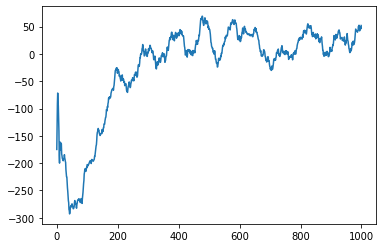

In [ ]:

import pandas as pd
df = pd.read_csv('kaggle_run_v14.txt', header=None)
df.columns = ['Final Reward', 'Score']

df['Steps'] = 0
df['Done'] = df['Final Reward'] == 100
df['Crashed'] = df['Final Reward'] == -100
# df[df['Done'] == True]
df['Rolling Scores'] = df.rolling(window=50, min_periods=1).mean()['Score']


plt.plot(df['Rolling Scores'])
df[df['Done']==True]
df[df['Crashed'] == True]

In [ ]:
len(df[df['Done'] == True]), len(df[df['Crashed'] == True])

(248, 534)

In [ ]:
from ipywidgets import GridspecLayout, Button, Layout, Image, Box, Label

def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

def image_widget(file):
    with open(file, "rb") as file:
        image = file.read()
        # return Image(value=image, width=w, height=h)
        return Image(value=image)

def image_label_widget(title, file):
    image = image_widget(file)
    label = Label(value=title)
    layout = Layout(display='flex', flex_flow='column', align_items='stretch', border='solid')
    box = Box(children=[image, label], layout=layout)
    return box

def display_gifs_grid(images, cols=5):
    rows = (len(images)+cols-1) // cols
    grid = GridspecLayout(rows, cols)

    for index, image in images.items():
        gcol = index%cols
        grow = index//cols

        grid[grow, gcol] = image_label_widget(str(index), image)
    
    return grid

display_gifs_grid(sims)

GridspecLayout(children=(Box(children=(Image(value=b'GIF89aX\x02\x90\x01\x87\x00\x00\xff\xff\xff\xfc\xfc\xfc\x…

In [ ]:
# model.load_weights('lunar_lander.kaggle.18.episode.395.h5')
model.load_weights('lunar_lander.kaggle.18.h5')

In [ ]:

def predicted_action(state):
    q_values = model(tf.expand_dims(state, 0))
    action = tf.squeeze(tf.argmax(q_values, axis=-1))
    return action.numpy()

def run():
    obs = env.reset()
    score = 0

    for step_id in range(1000):
        state = obs_to_state(obs)
        action = predicted_action(state)
        obs, reward, done, _ = env.step(action)
        score += reward

        if done:
            print('Finished with total score:', score, 'in steps: ', step_id)
            break
    
    print('Total Score:', score, 'Done:', done)

run()

Finished with total score: -97.38341341405015 in steps:  999
Total Score: -97.38341341405015 Done: True
